# Good and Bad Fruits Classification

## Part One: Imports and Data Visualization
Here, import the required libraries for this project. Furthermore, we define some constants. Furthermore, we load the data and visualize it.

In [77]:
import tensorflow as tensorflow
import matplotlib.pyplot as plt
import matplotlib.image as img
import pandas as pd 
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow import keras
import numpy as np
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os, os.path
import csv
import tensorflow_hub as hub

batch_size = 32
img_size = 256

Checking how data is organized

In [78]:
train_categories = []
train_samples = []
train_path = 'dataset/train/'

for i in os.listdir(train_path):
    train_categories.append(i)
    train_samples.append(len(os.listdir(train_path + i)))

test_samples = []
test_path = 'dataset/test/'
for i in os.listdir(test_path):
    test_samples.append(test_path + i)

print("Count of images in Training set:", sum(train_samples))
print("Count of images in Set set:", len(test_samples))

Count of images in Training set: 9036
Count of images in Set set: 12


Visualizing distributions of data

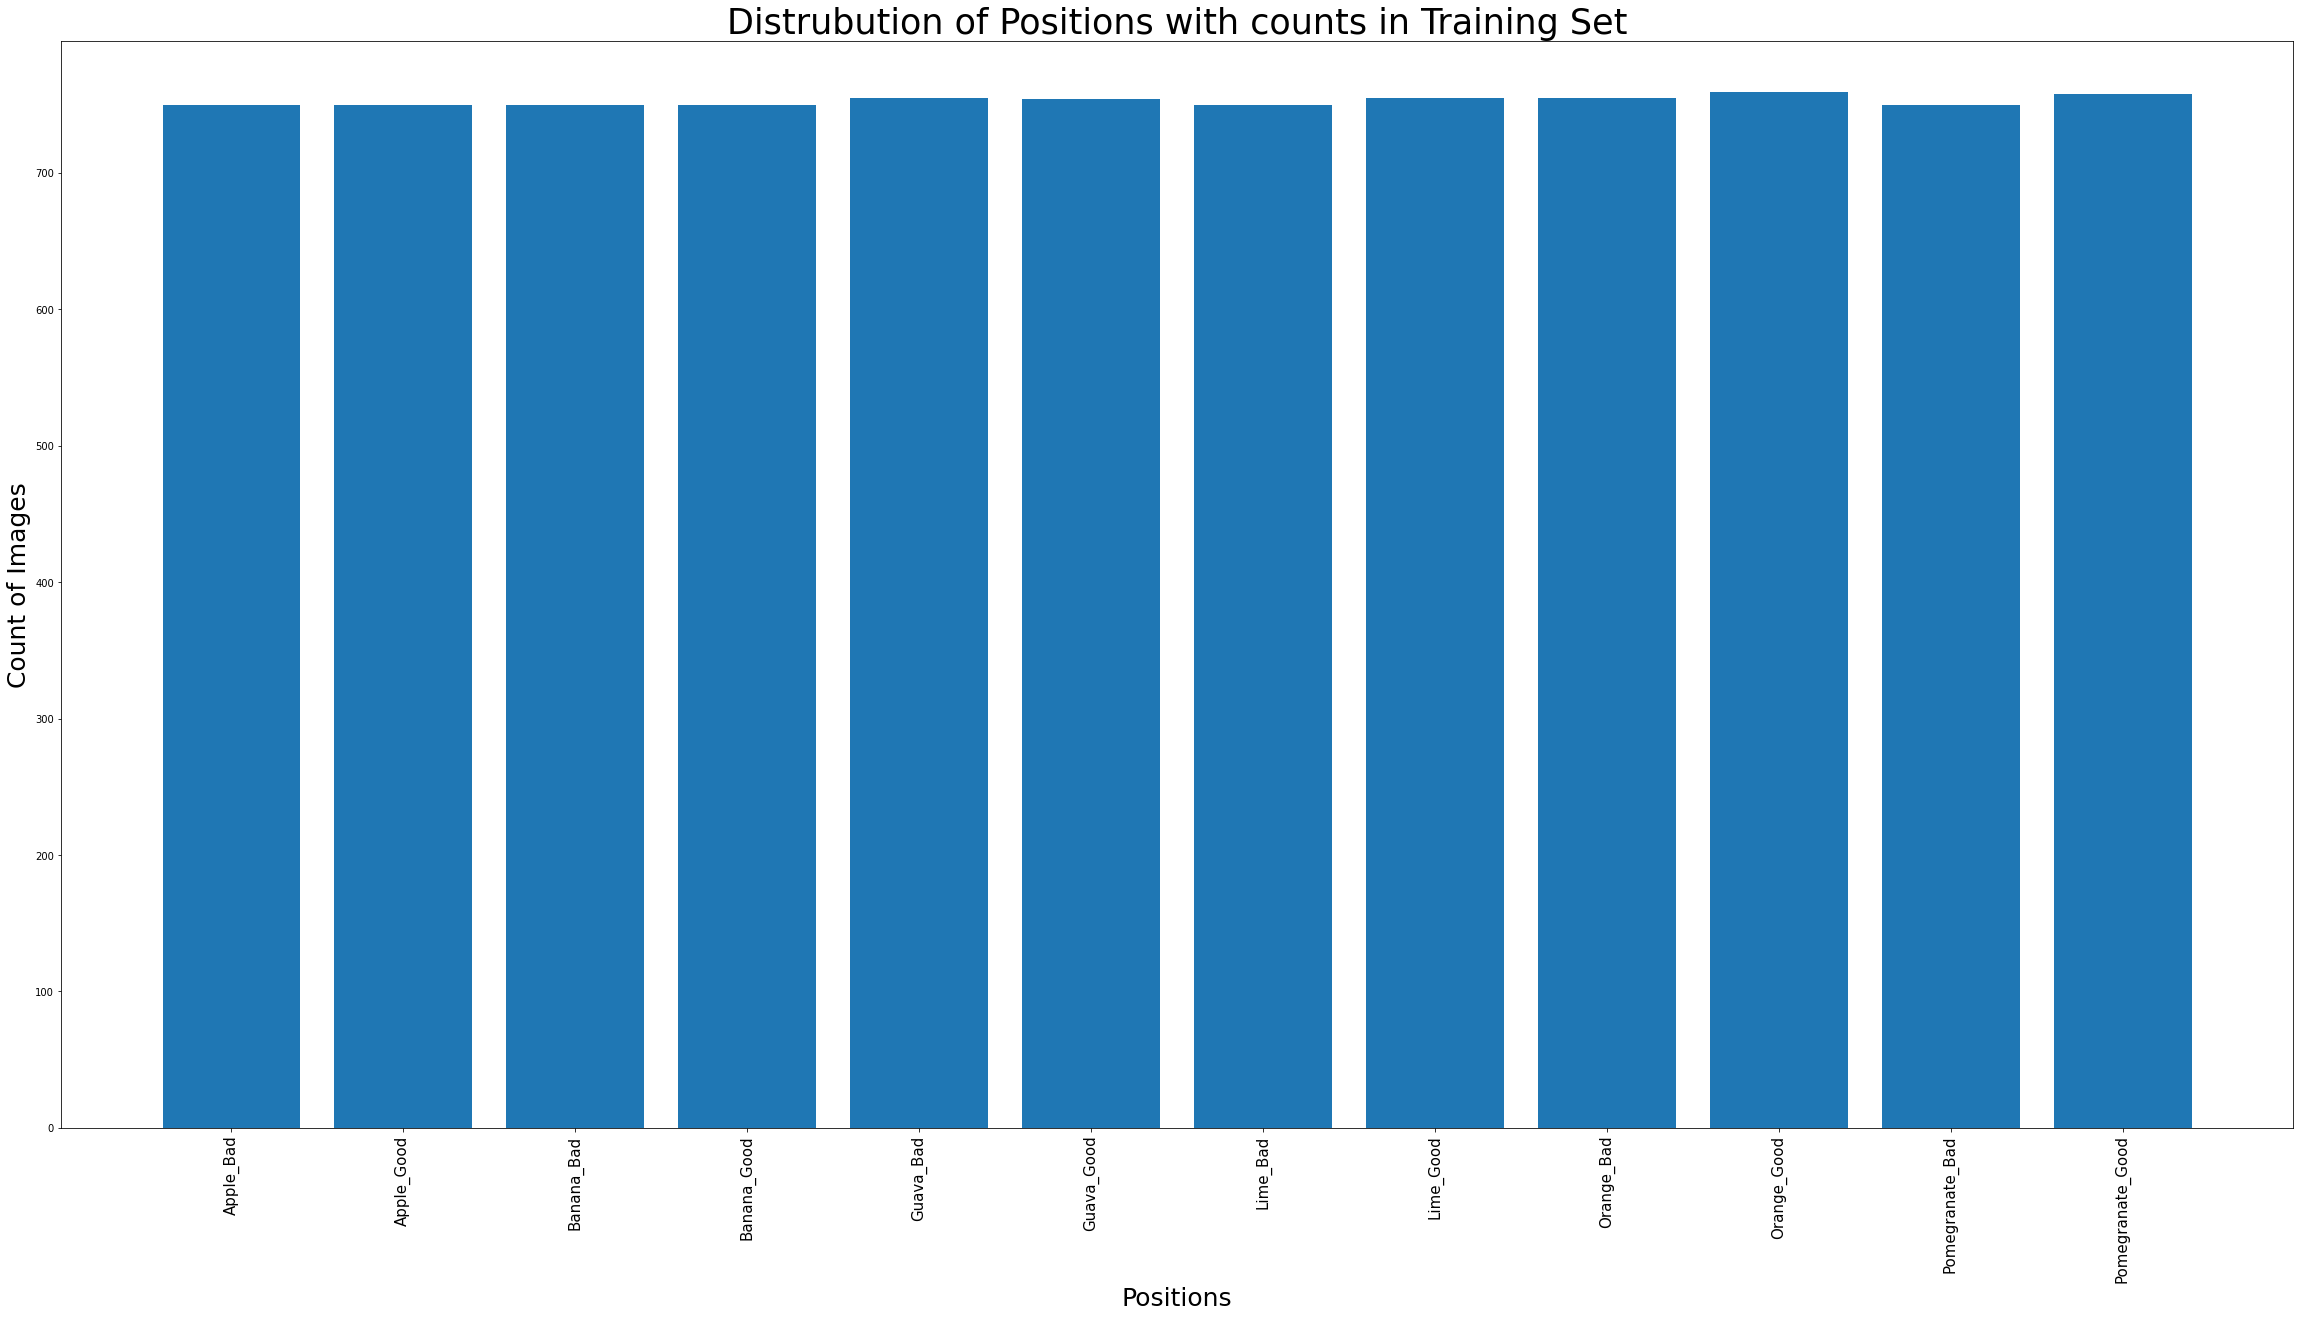

In [79]:
figure_size = plt.rcParams["figure.figsize"]
figure_size[0] = 40
figure_size[1] = 20
plt.rcParams["figure.figsize"] = figure_size
index = np.arange(len(train_categories))
plt.bar(index, train_samples)
plt.xlabel('Positions', fontsize=25)
plt.ylabel('Count of Images', fontsize=25)
plt.xticks(index, train_categories, fontsize=15, rotation=90)
plt.title('Distrubution of Positions with counts in Training Set', fontsize=35)
plt.show()

In [80]:
# Create a dictionary of labels and their corresponding index

label_to_index = dict((name, index) for index, name in enumerate(train_categories))
print(label_to_index)

# Create a dictionary of index and their corresponding labels

index_to_label = dict((index, name) for index, name in enumerate(train_categories))
print(index_to_label)


{'Apple_Bad': 0, 'Apple_Good': 1, 'Banana_Bad': 2, 'Banana_Good': 3, 'Guava_Bad': 4, 'Guava_Good': 5, 'Lime_Bad': 6, 'Lime_Good': 7, 'Orange_Bad': 8, 'Orange_Good': 9, 'Pomegranate_Bad': 10, 'Pomegranate_Good': 11}
{0: 'Apple_Bad', 1: 'Apple_Good', 2: 'Banana_Bad', 3: 'Banana_Good', 4: 'Guava_Bad', 5: 'Guava_Good', 6: 'Lime_Bad', 7: 'Lime_Good', 8: 'Orange_Bad', 9: 'Orange_Good', 10: 'Pomegranate_Bad', 11: 'Pomegranate_Good'}


Here, we will visualize some individual images.

Found 9036 images belonging to 12 classes.


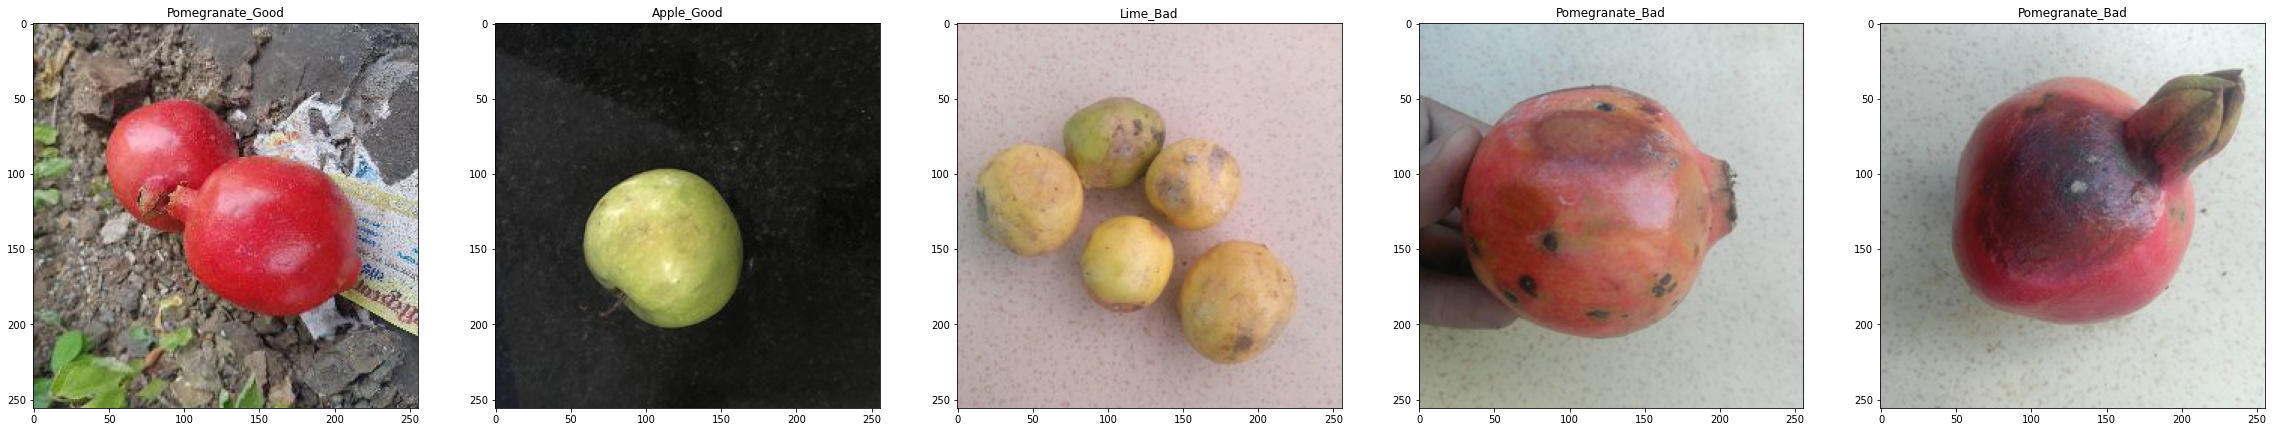

In [86]:
visualizer = ImageDataGenerator(
    rescale=1./255,
)
dir_it = visualizer.flow_from_directory(
    train_path,
    target_size=(img_size, img_size),
    class_mode='categorical',
    batch_size=5,
    seed = 42
)

x_batch, y_batch = next(dir_it)

saved_image = x_batch[0]
# Resize to (1, 256, 256, 3)
saved_image = np.expand_dims(saved_image, axis=0)

for i in range(5):
    image = x_batch[i]
    label = y_batch[i]
    # Display the images side by side
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title(index_to_label[np.argmax(label)])

While the dataset is already augmented, it doesn't hurt to do some image augmentation ourselves.
But since the images are already augmented, we will only do some mild augmentation.
Next, we display the augmented images. Taking the first image for example. Here you can see 10 variations of the same image.

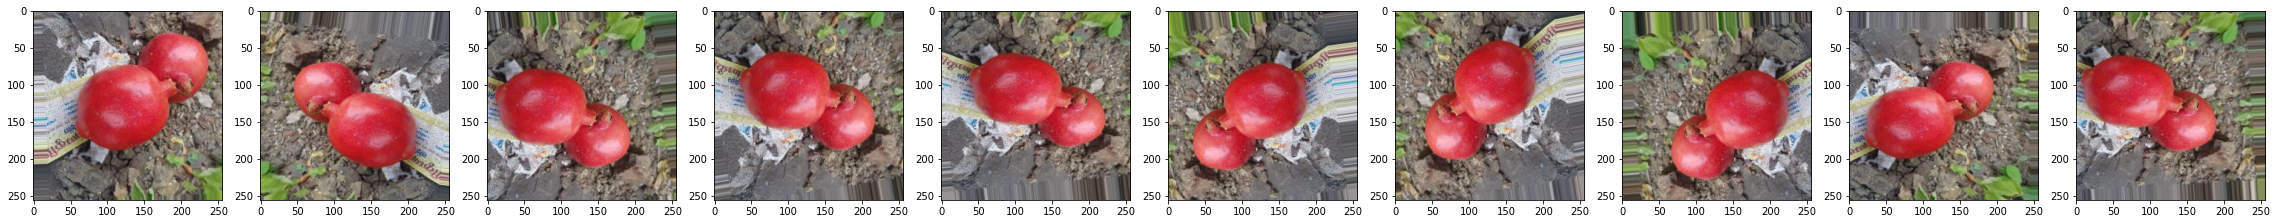

In [87]:
visualizer = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
    )


dir_it = visualizer.flow(
    saved_image,
    batch_size=1,
    seed=42,
)

# Get 10 augmented images of the first image
for i in range(10):
    x_batch = dir_it.next()
    image = x_batch[0]
    plt.subplot(1, 10, i+1)
    plt.imshow(image)

## Part Two: Creating the datasets

Here we will be creating the dataset we will be using in training

In [61]:
def get_dataset(path, batch_size, rescale, preprocess_function=None):
    aug_gens = ImageDataGenerator(
        rescale=rescale, # normalize pixel values to [0,1]
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.1,
        preprocessing_function=preprocess_function
    )

    train_data = aug_gens.flow_from_directory(
        path,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        seed = 1447)

    val_data = aug_gens.flow_from_directory(
        path,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        seed = 1447)
    
    return train_data, val_data

def get_testdataset(path, batch_size, rescale, preprocess_function=None):
    aug_gens = ImageDataGenerator(
        rescale=rescale, # normalize pixel values to [0,1]
        preprocessing_function=preprocess_function
    )
    
    test_data = aug_gens.flow_from_directory(
        path,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        seed = 1447)

    return test_data

train, val = get_dataset('dataset/train', batch_size, 1./255)
test = get_testdataset('dataset/test', batch_size, 1./255)

Found 8136 images belonging to 12 classes.
Found 900 images belonging to 12 classes.
Found 3013 images belonging to 12 classes.


Here we can see that the dataset generator initialized correctly

In [62]:
print(train.classes)
print(test.classes)

[ 0  0  0 ... 11 11 11]
[ 0  0  0 ... 11 11 11]


## Part Three: Basic Model

Here we will finally create our model!

We will start off with a very basic model to ensure everything is working!

In [63]:
model = keras.models.Sequential()

model.add(keras.layers.Input(shape=(img_size, img_size, 3)))
model.add(
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides = (1,1), padding = "same", activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding = "same", activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding = "same", activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding = "same", activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1048, activation='swish'))
model.add(keras.layers.Dense(128, activation='swish'))
model.add(keras.layers.Dense(len(train_categories), activation='softmax'))

model.build(input_shape=(None, img_size, img_size, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0

### Training
Now for the fun part.
We first start off by compiling the model with the Adam optimizer, and set the number of epochs to 10. Then we fit the model and display the accuracies in a graph.

In [64]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
num_epochs = 10
history = model.fit(train, workers = 8, epochs=num_epochs, validation_data=val, verbose = 1)

Epoch 1/10
255/255 [==============================] - 23s 61ms/step - loss: 1.1462 - accuracy: 0.5994 - val_loss: 0.9190 - val_accuracy: 0.6856
Epoch 2/10
255/255 [==============================] - 17s 62ms/step - loss: 0.4184 - accuracy: 0.8575 - val_loss: 0.9341 - val_accuracy: 0.7044
Epoch 3/10
255/255 [==============================] - 16s 61ms/step - loss: 0.2783 - accuracy: 0.9066 - val_loss: 0.8762 - val_accuracy: 0.7189
Epoch 4/10
255/255 [==============================] - 17s 64ms/step - loss: 0.2113 - accuracy: 0.9308 - val_loss: 1.0232 - val_accuracy: 0.7111
Epoch 5/10
255/255 [==============================] - 17s 64ms/step - loss: 0.2004 - accuracy: 0.9368 - val_loss: 0.8924 - val_accuracy: 0.7300
Epoch 6/10
255/255 [==============================] - 17s 64ms/step - loss: 0.1687 - accuracy: 0.9415 - val_loss: 0.7498 - val_accuracy: 0.8044
Epoch 7/10
255/255 [==============================] - 16s 62ms/step - loss: 0.1306 - accuracy: 0.9539 - val_loss: 0.8249 - val_accuracy:

From the training graph, we can see that the model is overfitting. This is because we are using a very simple model. We will try to improve the model in the next section.

### Visualization
Here, we will visualize the accuracy of the model as it trains.

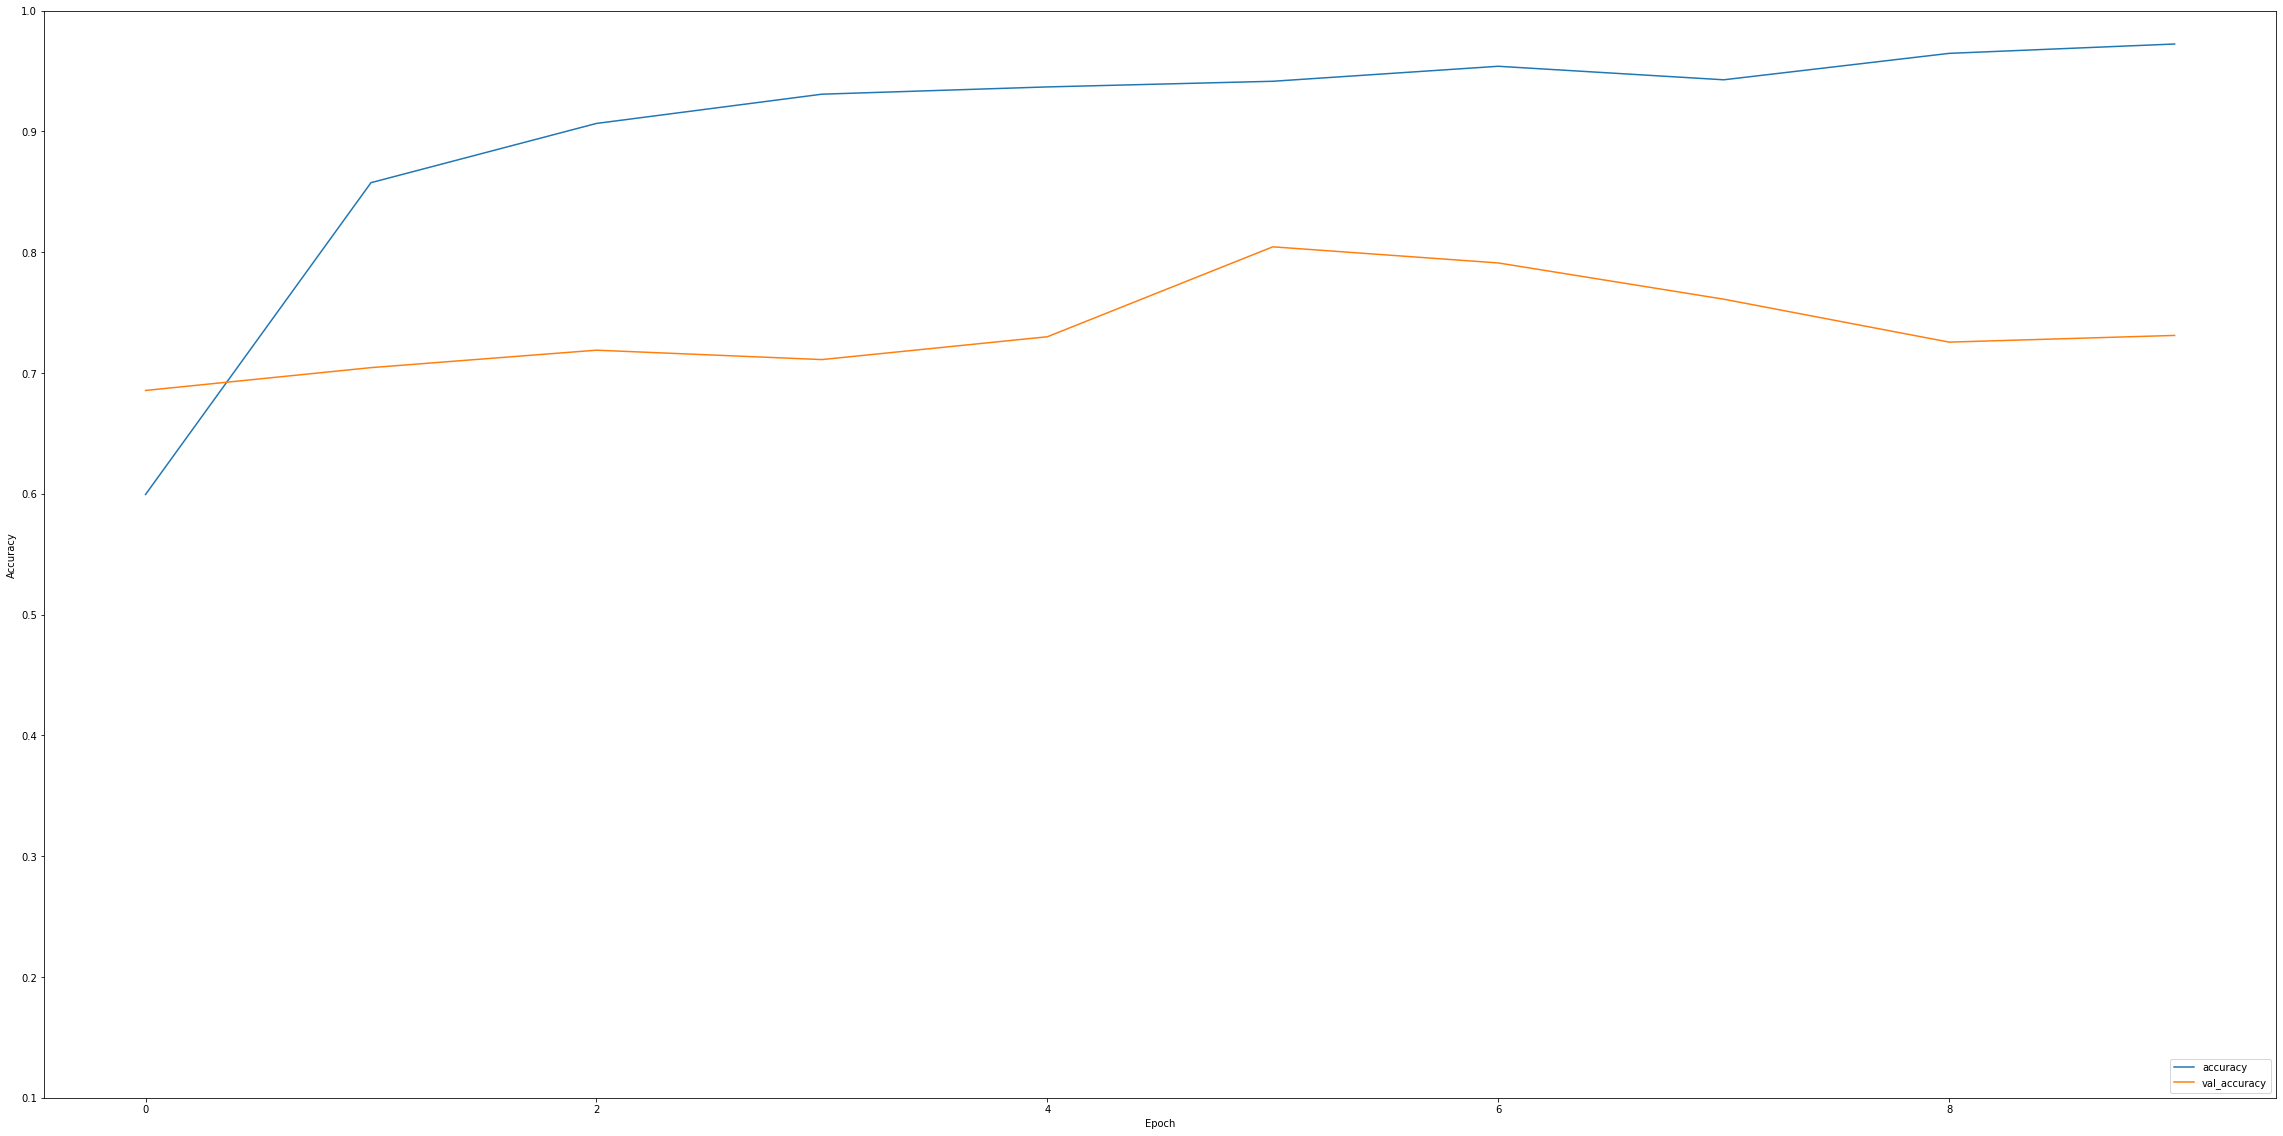

In [65]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')
plt.show()

### Test data
Lets see how well our model does on the test data. Surprisingly our test data has 95% accuracy!

In [67]:
model.evaluate(test)

95/95 [==============================] - 3s 31ms/step - loss: 0.1734 - accuracy: 0.9509


[0.17340683937072754, 0.9508795142173767]

## Part Four: Advanced Model

Here we will utilize transfer learning with a pretrained model. We will be using the MobileNet V2 Model since it is small, efficient, and fast. We will also redefine the input due to EfficientNet expecting different preprocessing requirements.

In [68]:
train, val = get_dataset('dataset/train/', batch_size, 1, preprocess_function=keras.applications.mobilenet_v2.preprocess_input)
test = get_testdataset('dataset/test', batch_size, 1, preprocess_function=keras.applications.mobilenet_v2.preprocess_input)

Found 8136 images belonging to 12 classes.
Found 900 images belonging to 12 classes.
Found 3013 images belonging to 12 classes.


In [71]:
mobNet = keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling = 'avg'
)

model = keras.models.Sequential()
model.add(keras.layers.Resizing(224, 224, interpolation='bilinear'))
model.add(mobNet)
model.add(keras.layers.Dense(1024, activation='swish'))
model.add(keras.layers.Dense(128, activation='swish'))
model.add(keras.layers.Dense(12, activation='softmax'))
model.build(input_shape=(None, img_size, img_size, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_6 (Dense)             (None, 1024)              1311744   
                                                                 
 dense_7 (Dense)             (None, 128)               131200    
                                                                 
 dense_8 (Dense)             (None, 12)                1548      
                                                                 
Total params: 3,702,476
Trainable params: 3,668,364
Non-trainable params: 34,112
_______________________________________

Again, we will compile the model. However, this time we will add three callbacks. 
 - The first call back will be a learning rate reduction. This will reduce the learning rate upon a plateau in loss to prevent overfitting. 
 - The second callback will be an early stopping callback. This call back will allow us to use a high number for epochs and yet the model will stop once it detects that the improvements have stopped.
 - The third callback will be a model checkpoint. This will allow us to save the model at the end of each epoch. This will allow us to use the best model for testing.

Once the three callbacks have been created, we will continue with training the model with the callbacks.

In [73]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
num_epochs = 100

lr_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=4, verbose=1,  factor=0.4, min_lr=0.0001)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=8, mode='auto', restore_best_weights=True)

MCP = keras.callbacks.ModelCheckpoint('Best_points.h5',
                      verbose=1,
                      save_best_only=True,
                      monitor='val_accuracy',
                      mode='max')

history = model.fit(train,
                    workers = 8,
                    epochs=num_epochs,
                    validation_data=val,
                    batch_size=batch_size,
                    verbose = 1,
                    callbacks = [early_stop, lr_reduction, MCP])

Epoch 1/100
255/255 [==============================] - ETA: 0s - loss: 0.3853 - accuracy: 0.8933
Epoch 1: val_accuracy improved from -inf to 0.13778, saving model to Best_points.h5
255/255 [==============================] - 40s 141ms/step - loss: 0.3853 - accuracy: 0.8933 - val_loss: 9.8109 - val_accuracy: 0.1378 - lr: 0.0010
Epoch 2/100
255/255 [==============================] - ETA: 0s - loss: 0.1691 - accuracy: 0.9534
Epoch 2: val_accuracy improved from 0.13778 to 0.18111, saving model to Best_points.h5
255/255 [==============================] - 34s 134ms/step - loss: 0.1691 - accuracy: 0.9534 - val_loss: 8.0542 - val_accuracy: 0.1811 - lr: 0.0010
Epoch 3/100
255/255 [==============================] - ETA: 0s - loss: 0.1427 - accuracy: 0.9621
Epoch 3: val_accuracy did not improve from 0.18111
255/255 [==============================] - 34s 133ms/step - loss: 0.1427 - accuracy: 0.9621 - val_loss: 10.0512 - val_accuracy: 0.1444 - lr: 0.0010
Epoch 4/100
255/255 [========================

Finally, we will evaluate the accuracy on the test dataset

In [74]:
model.evaluate(test)

95/95 [==============================] - 4s 37ms/step - loss: 0.1556 - accuracy: 0.9671


[0.1556209772825241, 0.9671424031257629]

Our validation accuracy is much higher than the basic model!

### Visualizing the accuracy
Here we will visualize the accuracy of the model as it trains.

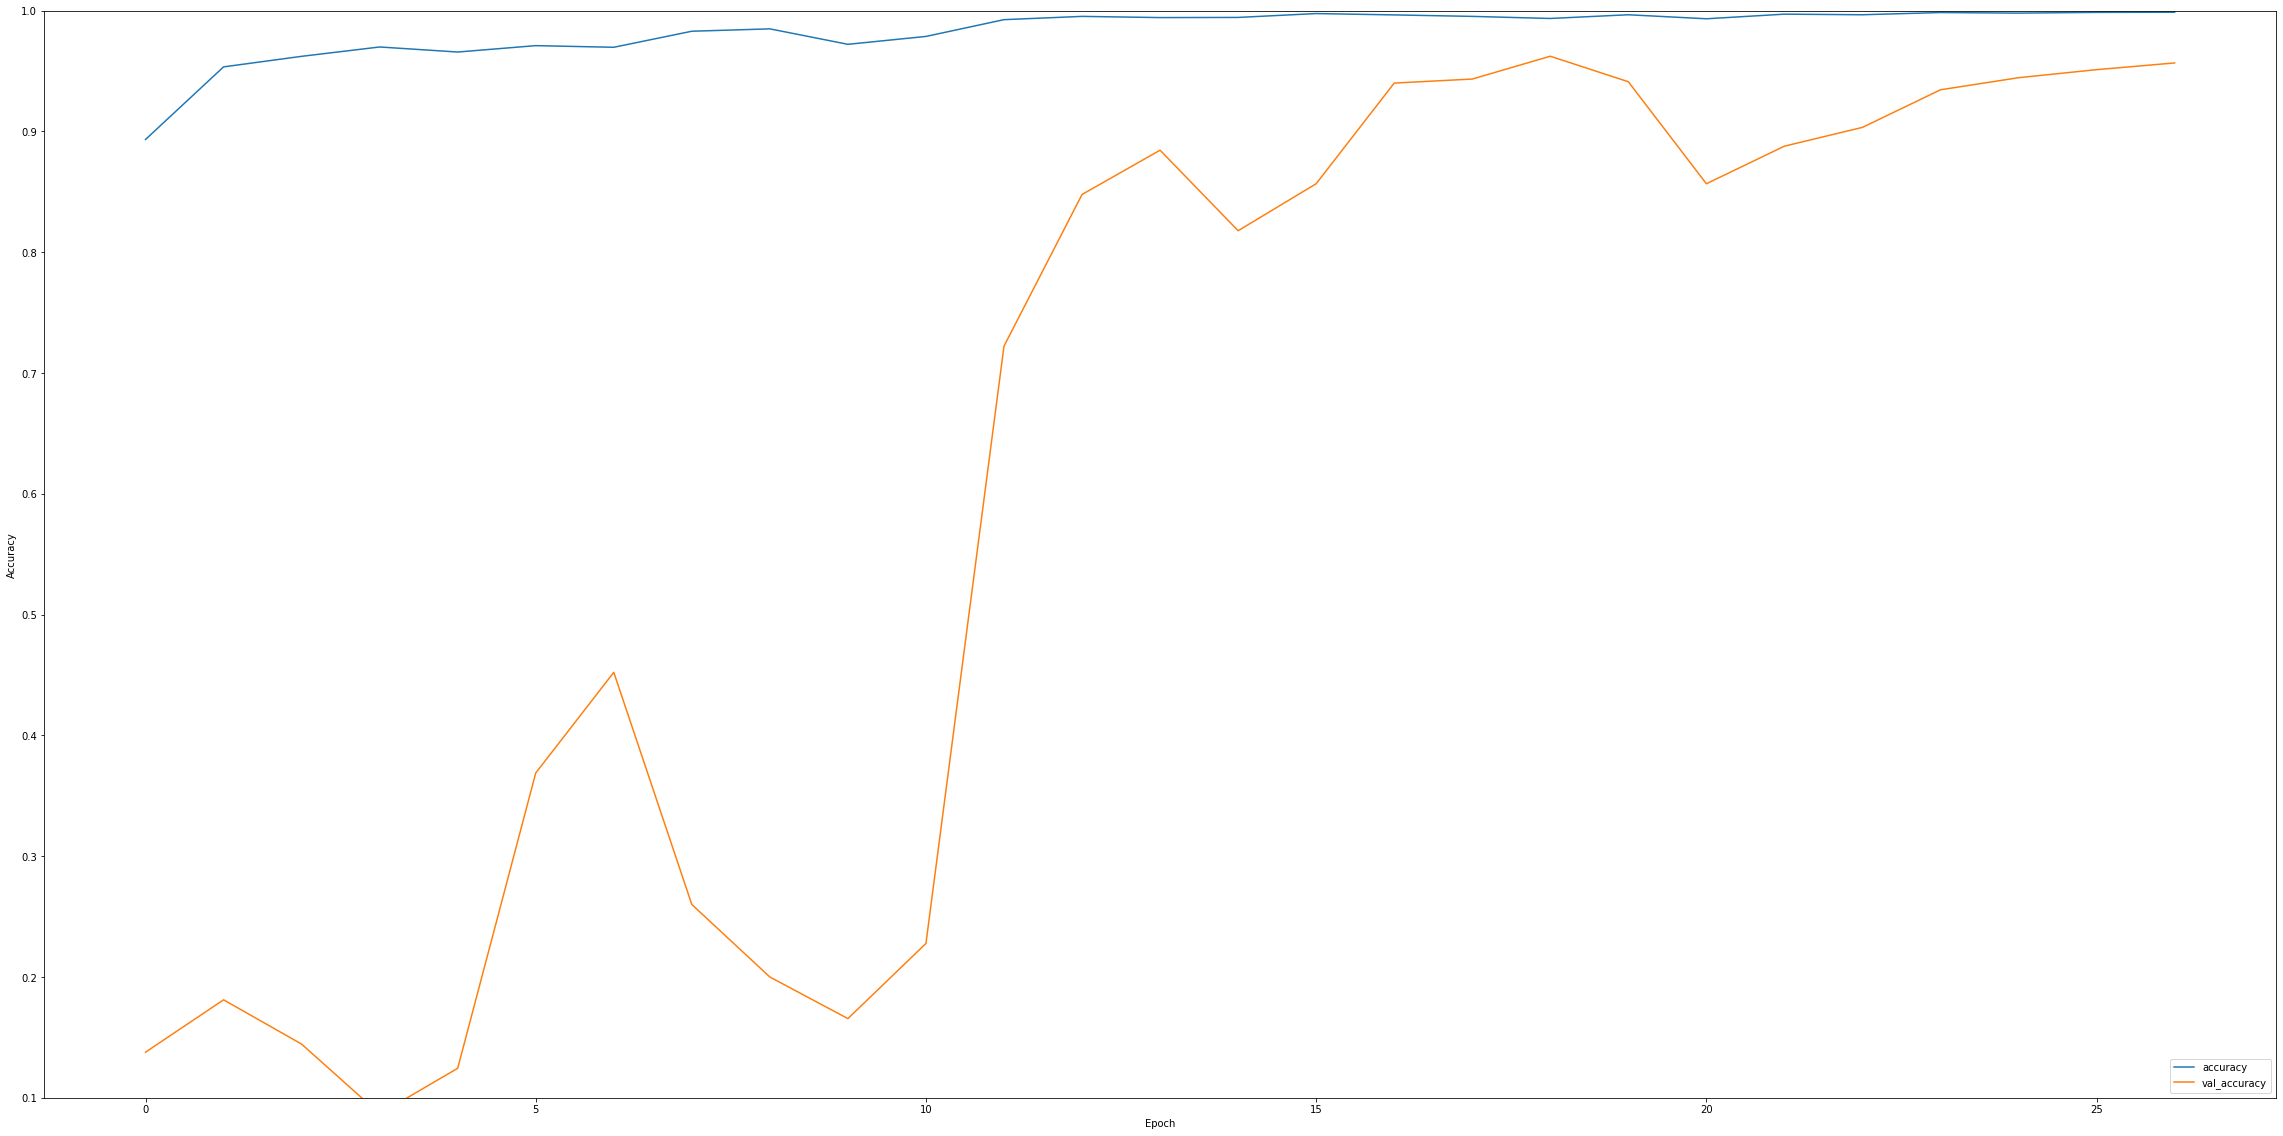

In [75]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')
plt.show()

## Part Five: Saving the model

First we load the model with the best weights

Then we save the model

In [76]:
# Loading the model with the best weights
model.load_weights('Best_points.h5')

# Saving the model as a savedModel
model.save('model', save_format='tf')


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets
